# 

# TF-IDF

In [34]:
import polars as pl
import os
import os
import re
import pickle

import joblib
from matplotlib import pyplot as plt
import nltk
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.model_selection import train_test_split

In [2]:
TASK_NAME = "tf-idf classifier"

In [3]:
from dotenv import load_dotenv

load_dotenv()

False

In [4]:
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

GlobalHydra.instance().clear()

# Hydra context initialization
initialize(version_base=None, config_path=".", job_name=TASK_NAME)
cfg = compose(config_name="config")

print(OmegaConf.to_yaml(cfg=cfg))

default:
- _self_
project:
  name: Toxic comments
dataset:
  project: Toxic comments
  name: Raw data
  file: toxic_comments.csv
params:
  nrows: 50000
  test_size: 0.2
  max_features: 10000
  random_state: 42
  shuffle: true



In [5]:
from clearml import Dataset, Task

# initialize ClearML tracking
task = Task.init(project_name=cfg.project.name, task_name=TASK_NAME, output_uri=True)

# initialize local version of dataset

dataset = Dataset.get(
    dataset_project=cfg.dataset.project, dataset_name=cfg.dataset.name
).get_local_copy()

task.set_progress(0)

ClearML Task: created new task id=3469821928234d4ca18e5436184b5d13
2024-05-22 20:45:55,386 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/ad182336b7f24902a01fce478ef1d156/experiments/3469821928234d4ca18e5436184b5d13/output/log
2024-05-22 20:46:00,636 - clearml - INFO - Dataset.get() did not specify alias. Dataset information will not be automatically logged in ClearML Server.
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [6]:
data = pl.read_csv(
    os.path.join(dataset, cfg.dataset.file),
    has_header=False,
    new_columns=["id", "text", "toxic"],
    n_rows=cfg.params.nrows,
)

pl.Config.set_fmt_str_lengths(100)
data.head(3)

id,text,toxic
i64,str,str
null,"""text""","""toxic"""
0,"""Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't…","""0"""
1,"""D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11…","""0"""


In [7]:
# Фиксируем прогресс выполнения в CLearML
task.set_progress(10)

In [8]:
data["toxic"].value_counts()

toxic,count
str,u32
"""1""",5147
"""toxic""",1
"""0""",44852


In [9]:
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# Compile templates for re expressions
stop_words = set(stopwords.words("english"))
url_pattern = re.compile(r"https?://\S+|www\.\S+|\[.*?\]|[^a-zA-Z\s]+|\w*\d\w*")
spec_chars_pattern = re.compile("[0-9 \-_]+")
non_alpha_pattern = re.compile("[^a-z A-Z]+")


def text_preprocessing(input_text: str) -> str:
    text = input_text.lower()
    text = url_pattern.sub("", text)
    text = spec_chars_pattern.sub(" ", text)
    text = non_alpha_pattern.sub(" ", text)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text.strip()


data = data.with_columns(
    pl.col("text").map_elements(text_preprocessing).str.split(" ").alias("corpus")
)

data.head(5)

sys:1: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



id,text,toxic,corpus
i64,str,str,list[str]
null,"""text""","""toxic""","[""text""]"
0,"""Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't…","""0""","[""explanation"", ""edits"", … ""retired""]"
1,"""D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11…","""0""","[""daww"", ""matches"", … ""utc""]"
2,"""Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant …","""0""","[""hey"", ""man"", … ""info""]"
3,""""" More I can't make any real suggestions on improvement - I wondered if the section statistics sho…","""0""","[""cant"", ""make"", … ""wikipediagoodarticlenominationstransport""]"


In [11]:
def lemmatize(input_frame: pl.DataFrame) -> pl.DataFrame:
    lemmatizer = WordNetLemmatizer()

    return input_frame.with_columns(
        pl.col("corpus").map_elements(
            lambda input_list: [lemmatizer.lemmatize(token) for token in input_list]
        )
    )


processed_data = lemmatize(data)
processed_data.head(5)

C:\Users\Иван\AppData\Local\Temp\ipykernel_13860\1245396546.py:4: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



id,text,toxic,corpus
i64,str,str,list[str]
null,"""text""","""toxic""","[""text""]"
0,"""Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't…","""0""","[""explanation"", ""edits"", … ""retired""]"
1,"""D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11…","""0""","[""daww"", ""match"", … ""utc""]"
2,"""Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant …","""0""","[""hey"", ""man"", … ""info""]"
3,""""" More I can't make any real suggestions on improvement - I wondered if the section statistics sho…","""0""","[""cant"", ""make"", … ""wikipediagoodarticlenominationstransport""]"


In [12]:
# Capture execution progress in CLearML
task.set_progress(20)

# Fixing artifacts in clearML
task.upload_artifact(name="Processed data", artifact_object=processed_data)

True

In [13]:
vectorizer_params = {"max_features": cfg.params.max_features, "analyzer": "word"}

tfidf_vectorizer = TfidfVectorizer(**vectorizer_params)

train, test = train_test_split(
    processed_data,
    test_size=cfg.params.test_size,
    shuffle=cfg.params.shuffle,
    random_state=cfg.params.random_state,
)

tfidf_vectorizer.fit(train["corpus"].to_pandas().astype(str))

train_features = tfidf_vectorizer.transform(train["corpus"].list.join(" ").to_numpy())
test_features = tfidf_vectorizer.transform(test["corpus"].list.join(" ").to_numpy())

In [14]:
tfidf_vectorizer

TfidfVectorizer(max_features=10000)

In [15]:
# Fixing progress in
task.set_progress(50)

# fixing artifacts
task.upload_artifact(name="TfidfVectorizer", artifact_object=pickle.dumps(tfidf_vectorizer))

task.upload_artifact(
    name="train_features",
    artifact_object=(train_features, train["toxic"].to_numpy()),
)

task.upload_artifact(
    name="test_features",
    artifact_object=(test_features, test["toxic"].to_numpy()),
)

True

In [16]:
model_params = {
    "random_state": cfg.params.random_state,
    "multi_class": "multinomial",
    "solver": "saga",
}

model_lr = LogisticRegression(**model_params)

model_lr.fit(train_features, train["toxic"])

LogisticRegression(multi_class='multinomial', random_state=42, solver='saga')

In [17]:
# Fix the progress of execution
task.set_progress(80)
# Fixing artifacts in clearML
task.upload_artifact(name="LogisticRegression", artifact_object=pickle.dumps(model_lr))

True

In [35]:
predicts = model_lr.predict(test_features)


# metrics_of_model = {
#     "accuracy": accuracy_score(test["toxic"], predicts),
#     # "recall": recall_score(test["toxic"], predicts),
#     "precision": precision_score(test["toxic"], predicts),
#     # "roc_auc_score": roc_auc_score(test["toxic"], predicts),
# }

report = classification_report(test["toxic"], predicts, output_dict=True)

conf_matrix = confusion_matrix(test["toxic"], predicts)

In [37]:
# Fix progress in CLearML
task.set_progress(95)

# Fix parameters of model
logger = task.get_logger()

logger.report_single_value("Accuracy", report.pop("accuracy"))

for class_name, metrics in report.items():
    for metric, value in metrics.items():
        logger.report_single_value(f"{class_name}_{metric}", value)

logger.report_confusion_matrix("Confusion matrix", "ignored", matrix=conf_matrix)


In [38]:
# Finish experiment
task.close()


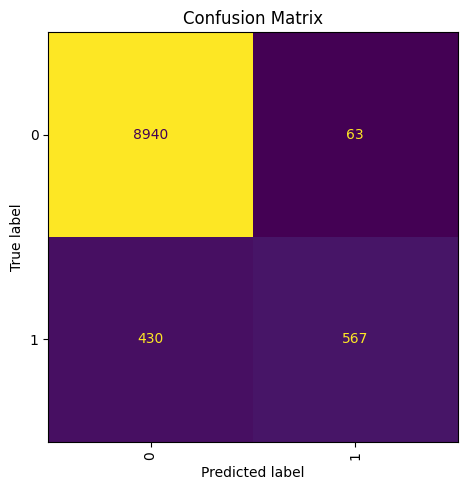

In [40]:
%matplotlib inline


fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(test["toxic"], predicts, ax=ax, colorbar=False)
ax.xaxis.set_tick_params(rotation=90)
_ = ax.set_title("Confusion Matrix")
plt.tight_layout()
